In [1]:
from __future__ import print_function
import os
import sys
sys.path.append('../../../../')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch import multiprocessing, cuda
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.backends import cudnn
import seaborn as sns
import importlib
import os
from tqdm import tqdm
import voc12.dataloader
from misc import torchutils, imutils, myutils
import torchvision.transforms as transforms

In [2]:
GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '6'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [3]:
CAM_DIR = '/raid/maruf/WSS/CAM_original'

In [4]:
CLASSNAME_LIST = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

# Load Dataset

In [5]:
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainercv.evaluations import calc_semantic_segmentation_confusion

# ground truth labels in gt_labels

gt_dataset = VOCSemanticSegmentationDataset(split="train",
                                            data_dir='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012')

gt_labels = [gt_dataset.get_example_by_keys(i, (1,))[0] for i in range(len(gt_dataset))]


# segmentation dataset and data_loader 

dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(img_name_list_path='/home/amartyadutta/VOC12/AMN/voc12/train.txt',
                                                         voc12_root='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012', 
                                                         scales=(1.0,))

data_loader = DataLoader(dataset, shuffle=False)

# NDR gt corresponds to non-deterministic region ground truths

ndr_gt_labels = [np.load(os.path.join('/raid/maruf/WSS/NDR_ground_truth', id + '.npy'), allow_pickle=True) for id in gt_dataset.ids]

# DR gt corresponds to non-deterministic region ground truths

dr_gt_labels = [np.load(os.path.join('/raid/maruf/WSS/DR_ground_truth', id + '.npy'), allow_pickle=True) for id in gt_dataset.ids]

# Load Model

In [6]:
model = getattr(importlib.import_module('net.resnet50_cam'), 'CAM_original')()
model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam.pth' + '.pth', map_location='cpu'), strict=True)
model.eval()

model = model.cuda()

In [7]:
with torch.no_grad():
    
    for iter, pack in enumerate(tqdm(data_loader)):
        
        img_name = pack['name'][0]
        
        if os.path.exists(os.path.join(CAM_DIR, img_name+'.npy')):
            continue
        
        label = pack['label'][0]
        cls_label = torch.nonzero(label)[:, 0]
        size = pack['size']
        
        input_img = pack['img'][0][0:1, ...]
        
        cam_output = model(input_img.cuda(), clf=False)
        
        strided_up_size = imutils.get_strided_up_size(size, 16)
        
        
        highres_cam = F.interpolate(
            cam_output,
            strided_up_size,
            mode='bilinear',
            align_corners=False
        )[..., :size[0], :size[1]][0]
        
        highres_cam = highres_cam[cls_label]
        highres_cam /= F.adaptive_max_pool2d(highres_cam, (1, 1)) + 1e-5
        
        np.save(os.path.join(CAM_DIR, img_name+'.npy'), 
                {'cam': highres_cam.cpu().numpy(), 'cls_label': cls_label})
        
        
        

100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:15<00:00, 95.79it/s]


# Choose thresholds

In [8]:
def get_predictions(thres=0.25):
    
    preds = []
    
    for id in tqdm(gt_dataset.ids):
        
        cam_obj = np.load(os.path.join(CAM_DIR, id + '.npy'), allow_pickle=True).item()
        
        cams = np.pad(cam_obj['cam'], 
              ((1, 0), (0, 0), (0, 0)), 
              mode='constant', 
              constant_values=thres)

        keys = np.pad(cam_obj['cls_label']+ 1, 
                      (1, 0), 
                      mode='constant')
        
        cls_labels = np.argmax(cams, axis=0)
        
        cls_labels = keys[cls_labels]
        
        preds.append(cls_labels.copy())
        
    return preds

In [20]:
from metrics.metric import compute_miou, compute_dr_recall, compute_ndr_recall, compute_mPrecision

In [11]:
def viz_first_n_cams(n=10, thres=0.25):
    
    for iter, pack in enumerate(data_loader):
        
        img_name = pack['name'][0]
        
        input_img = pack['img'][0][0:1, ...]
        
        cam_obj = np.load(os.path.join(CAM_DIR, img_name + '.npy'), allow_pickle=True).item()
        
        cams = np.pad(cam_obj['cam'], 
              ((1, 0), (0, 0), (0, 0)), 
              mode='constant', 
              constant_values=thres)

        keys = np.pad(cam_obj['cls_label']+ 1, 
                      (1, 0), 
                      mode='constant')
        
        cls_labels = np.argmax(cams, axis=0)
        
        predicted_cam = keys[cls_labels]
        # gt_cam = gt_labels[iter]
        gt_label = gt_labels[iter]
        ndr_gt_label = ndr_gt_labels[iter]
        dr_gt_label = dr_gt_labels[iter]
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
        ax[0].imshow(myutils.unnormalize_image(input_img))
        ax[0].axis('off')
        # ax[0].set_title('miou:{:.2f}'.format(compute_miou([predicted_cam], [gt_cam])))
        ax[0].set_title('iou:{:.2f}\nNDR-iou:{:.2f}\nDR-iou:{:.2f}\nFG-Precision:{:.2f}'.format(compute_miou([predicted_cam], [gt_label]),
                                                                                                compute_ndr_recall([predicted_cam], [ndr_gt_label]),
                                                                                                compute_dr_recall([predicted_cam], [dr_gt_label]),
                                                                                                compute_mPrecision([predicted_cam], [gt_label])))
        
        sns.heatmap(gt_label, vmax='20', cmap='tab20', ax=ax[1])
        ax[1].axis('off')
        ax[1].set_title('Ground Truth')
        sns.heatmap(predicted_cam, vmax='20', cmap='tab20', ax=ax[2])
        ax[2].axis('off')
        ax[2].set_title('CAM prediction')
        plt.show()
        
        if iter+1 == n:
            break
        

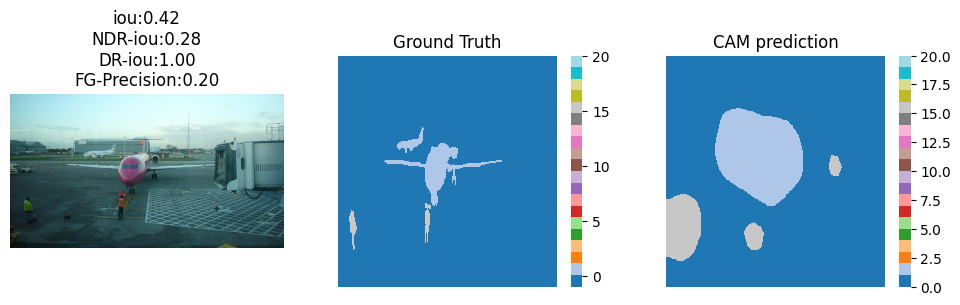

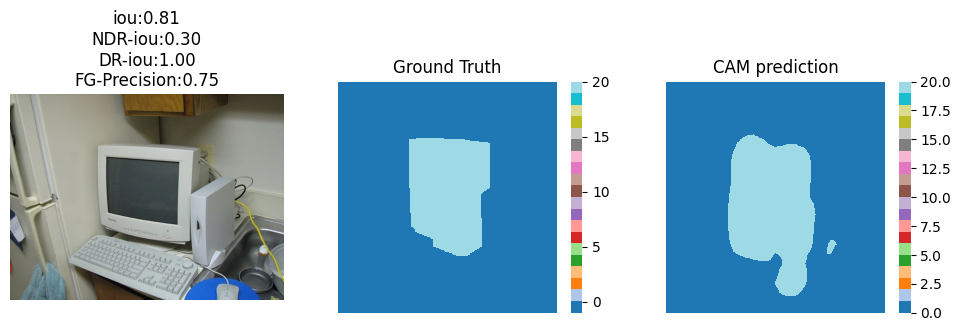

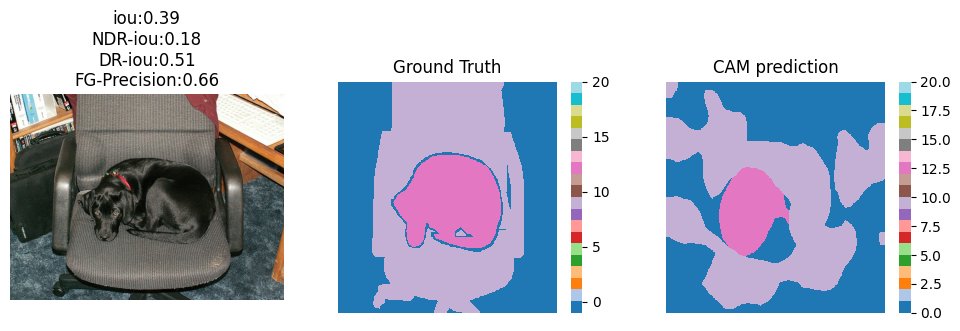

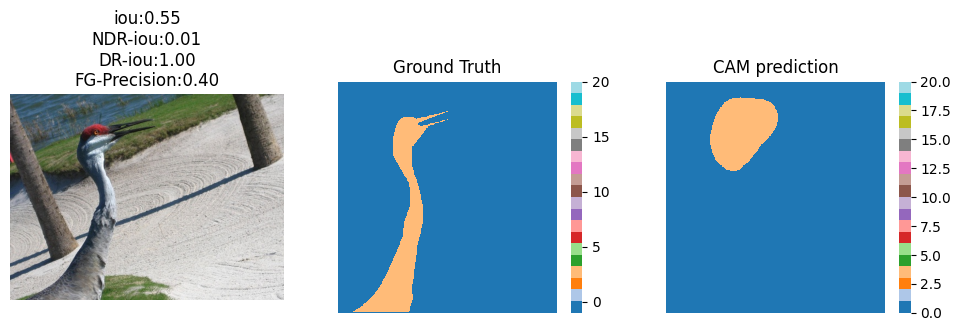

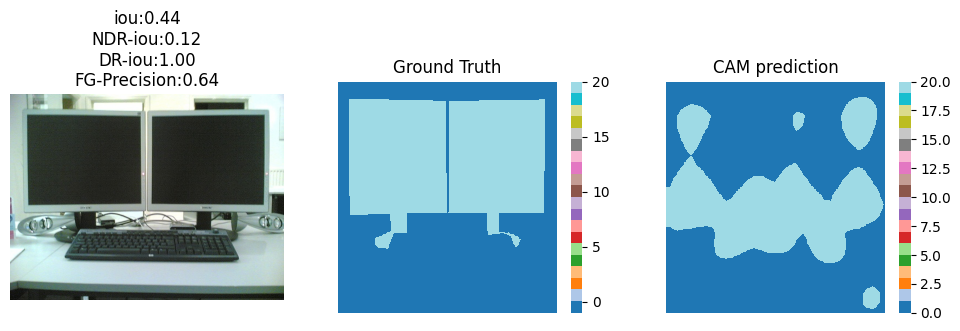

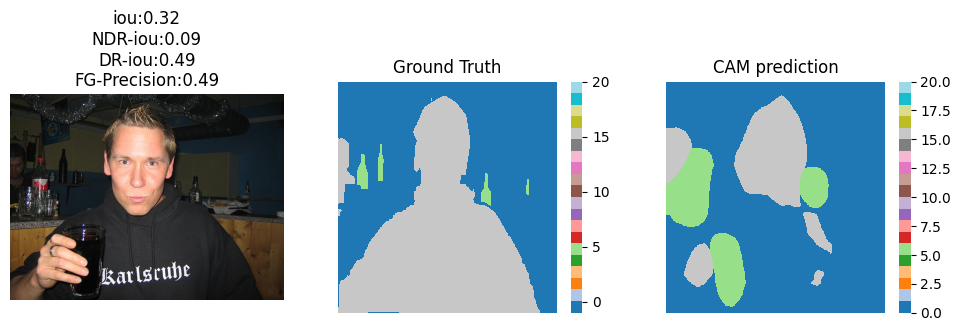

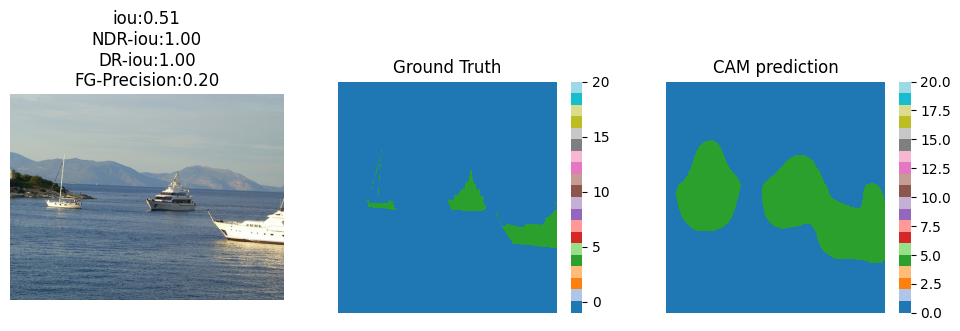

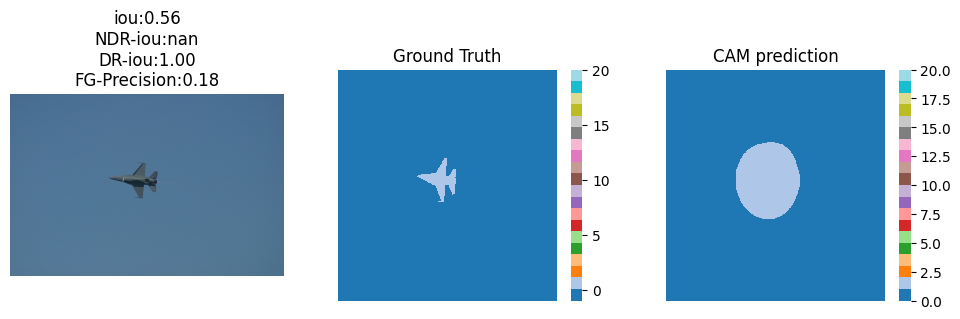

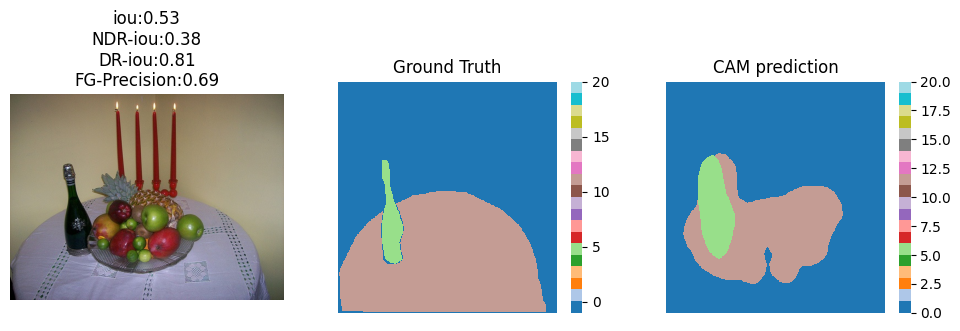

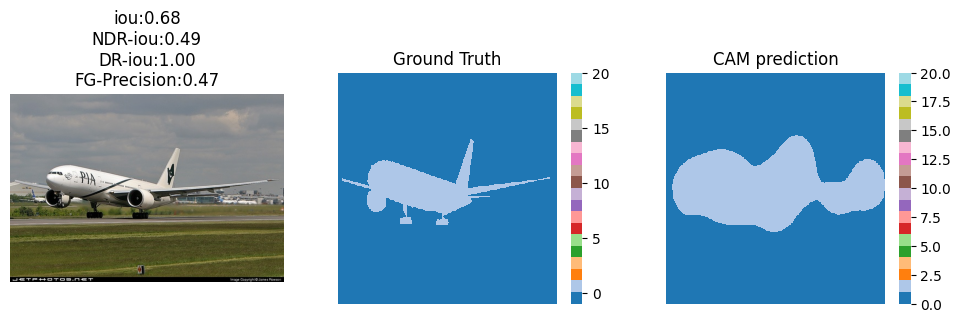

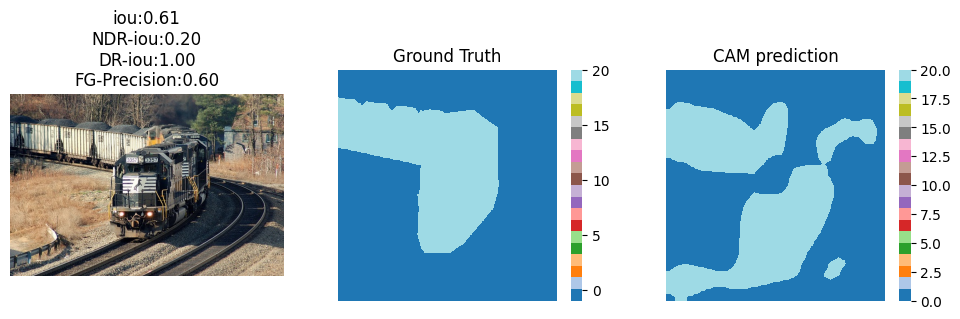

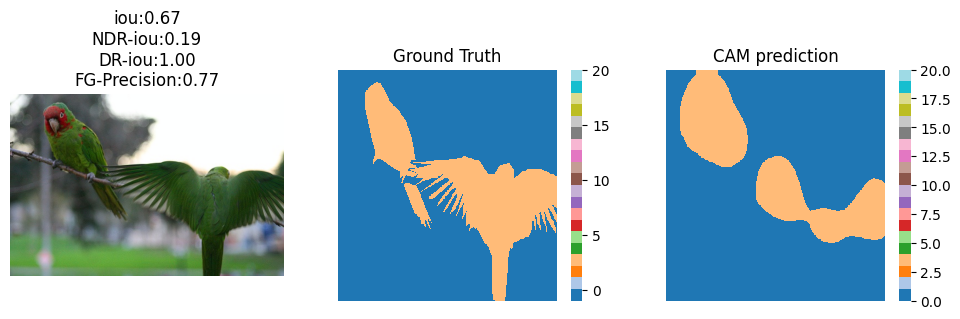

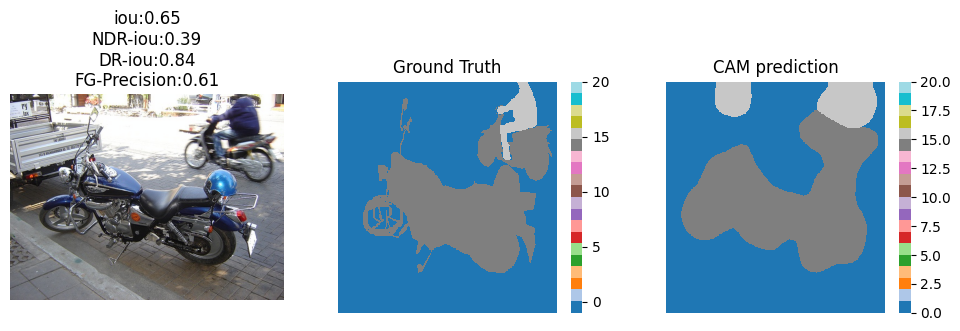

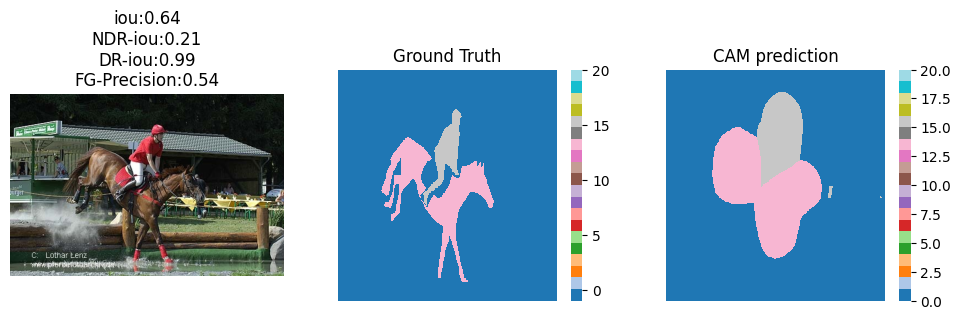

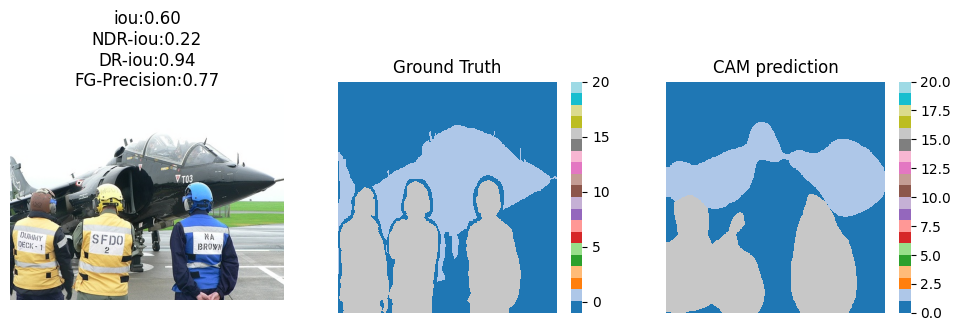

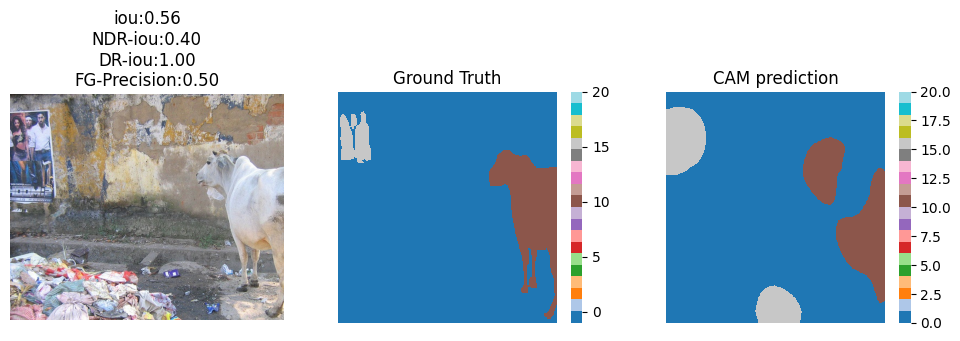

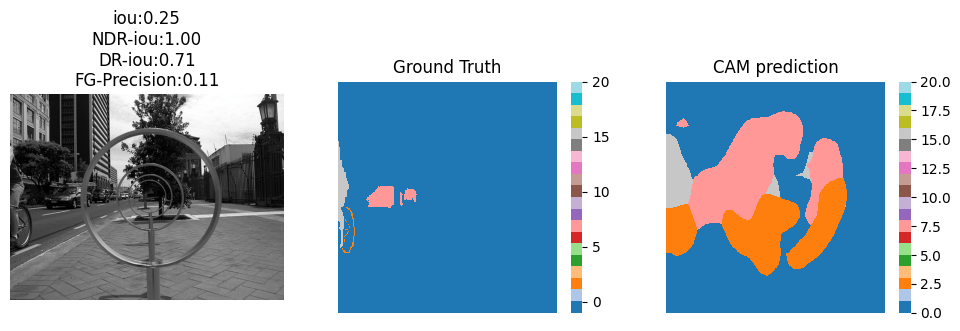

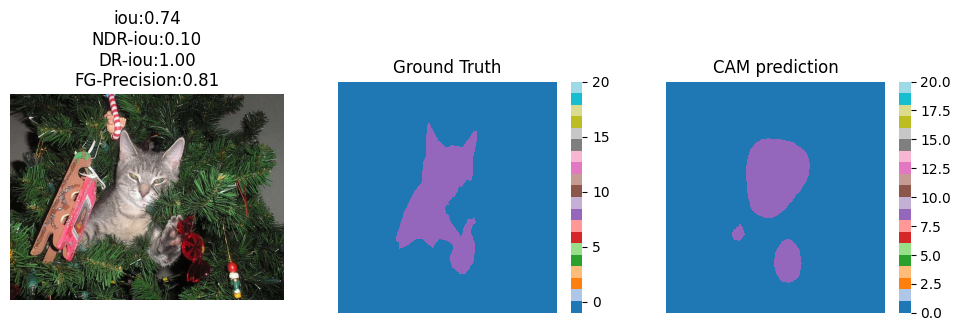

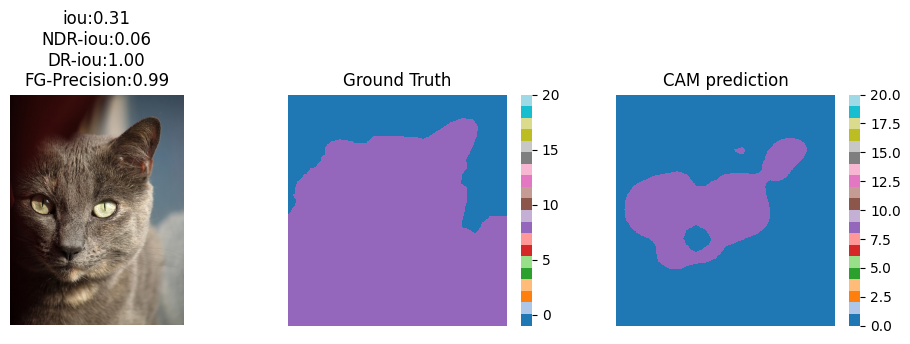

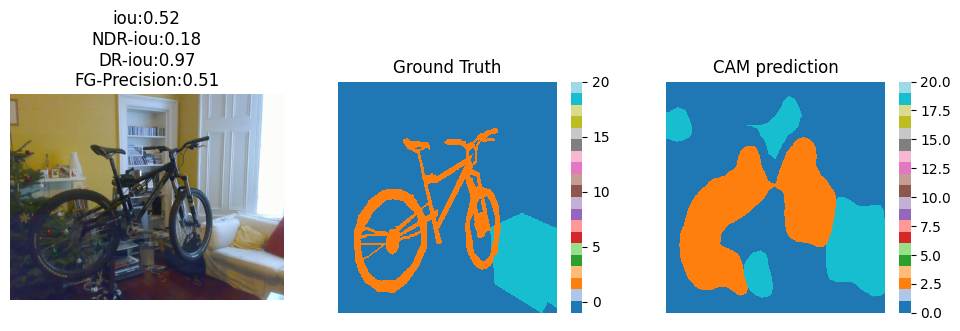

In [12]:
viz_first_n_cams(n=20, thres=0.15)

In [13]:
thresholds = [round(i, 2) for i in np.arange(0.01, 0.20, .01)]



mious = []
ndrmiou = []
drmiou = []
precision = []

for thres in thresholds:
    
    preds = get_predictions(thres=thres)
    
    miou = compute_miou(preds, gt_labels)
    mious.append(miou)
    
    ndr_miou = compute_ndr_recall(preds, ndr_gt_labels)
    ndrmiou.append(ndr_miou)
    
    dr_miou = compute_dr_recall(preds, dr_gt_labels)
    drmiou.append(dr_miou)
    
    prec = compute_mPrecision(preds, gt_labels)
    precision.append(prec)
    
    print(f'\nmIoU for {thres}: {miou}\nNDR-Recall for {thres}: {ndr_miou}\nDR-Recall for {thres}: {dr_miou}\nFG-Precision for {thres}: {prec}\n\n')

100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:16<00:00, 86.78it/s]



mIoU for 0.01: 0.3870440025491909
NDR-Recall for 0.01: 0.6098013285217639
DR-Recall for 0.01: 0.8807611727361355
FG-Precision for 0.01: 0.4258196233392101




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:15<00:00, 92.29it/s]



mIoU for 0.02: 0.40995883788859233
NDR-Recall for 0.02: 0.5718068109834531
DR-Recall for 0.02: 0.8807611727361355
FG-Precision for 0.02: 0.46333343648197045




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:15<00:00, 92.31it/s]



mIoU for 0.03: 0.4219805803652052
NDR-Recall for 0.03: 0.5388741710010814
DR-Recall for 0.03: 0.8807611727361355
FG-Precision for 0.03: 0.48814895517795376




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 110.91it/s]



mIoU for 0.04: 0.4289924890940674
NDR-Recall for 0.04: 0.5081622514556885
DR-Recall for 0.04: 0.8807611727361355
FG-Precision for 0.04: 0.507257563306215




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:14<00:00, 104.32it/s]



mIoU for 0.05: 0.4333860570850023
NDR-Recall for 0.05: 0.47928080348459984
DR-Recall for 0.05: 0.8807611727361355
FG-Precision for 0.05: 0.5233528866426106




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 110.83it/s]



mIoU for 0.06: 0.43592293254813425
NDR-Recall for 0.06: 0.4516068769017589
DR-Recall for 0.06: 0.8807611727361355
FG-Precision for 0.06: 0.5373602901031742




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:12<00:00, 112.65it/s]



mIoU for 0.07: 0.4370913611382463
NDR-Recall for 0.07: 0.4248018635213017
DR-Recall for 0.07: 0.8807611727361355
FG-Precision for 0.07: 0.5498254002719466




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:15<00:00, 96.76it/s]



mIoU for 0.08: 0.4371987182053025
NDR-Recall for 0.08: 0.3987044997848179
DR-Recall for 0.08: 0.8807611727361355
FG-Precision for 0.08: 0.5611367101958826




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 112.48it/s]



mIoU for 0.09: 0.43637053618475946
NDR-Recall for 0.09: 0.3730089640547688
DR-Recall for 0.09: 0.8807611727361355
FG-Precision for 0.09: 0.571456649059285




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:17<00:00, 84.83it/s]



mIoU for 0.1: 0.43473185335213205
NDR-Recall for 0.1: 0.3475715153621931
DR-Recall for 0.1: 0.8807611727361355
FG-Precision for 0.1: 0.580934702074039




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 112.29it/s]



mIoU for 0.11: 0.43246943334036814
NDR-Recall for 0.11: 0.3225087303966236
DR-Recall for 0.11: 0.8807611727361355
FG-Precision for 0.11: 0.5897735575984095




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:14<00:00, 98.81it/s]



mIoU for 0.12: 0.4296177118005974
NDR-Recall for 0.12: 0.2975906758956847
DR-Recall for 0.12: 0.8807611727361355
FG-Precision for 0.12: 0.5980111686671499




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 110.44it/s]



mIoU for 0.13: 0.42632824422879634
NDR-Recall for 0.13: 0.27301755374605885
DR-Recall for 0.13: 0.8807611727361355
FG-Precision for 0.13: 0.6058036516048971




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 111.78it/s]



mIoU for 0.14: 0.42262914632972176
NDR-Recall for 0.14: 0.24880191492023873
DR-Recall for 0.14: 0.8807611727361355
FG-Precision for 0.14: 0.6131657966658076




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 104.81it/s]



mIoU for 0.15: 0.41861269445024524
NDR-Recall for 0.15: 0.2249741473966194
DR-Recall for 0.15: 0.8807611727361355
FG-Precision for 0.15: 0.620193582136856




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 111.62it/s]



mIoU for 0.16: 0.41423190548173444
NDR-Recall for 0.16: 0.20130744161170347
DR-Recall for 0.16: 0.8807611727361355
FG-Precision for 0.16: 0.6268871530186833




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:16<00:00, 87.34it/s]



mIoU for 0.17: 0.40967460611865275
NDR-Recall for 0.17: 0.17808512656685607
DR-Recall for 0.17: 0.8807611727361355
FG-Precision for 0.17: 0.6333665148680857




100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:13<00:00, 112.26it/s]



mIoU for 0.18: 0.4048908697032731
NDR-Recall for 0.18: 0.1550919305682889
DR-Recall for 0.18: 0.8807611727361355
FG-Precision for 0.18: 0.6395800806965714




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:15<00:00, 91.85it/s]



mIoU for 0.19: 0.399828642950776
NDR-Recall for 0.19: 0.1320670424312997
DR-Recall for 0.19: 0.8807611727361355
FG-Precision for 0.19: 0.6455648922604793




In [14]:
print(f'Max miou={max(mious)}, \nMax ndr-recall={max(ndrmiou)},\n Max dr-recall={max(drmiou)},\n Max FG-Precision={max(precision)}')

Max miou=0.4371987182053025, 
Max ndr-recall=0.6098013285217639,
 Max dr-recall=0.8807611727361355,
 Max FG-Precision=0.6455648922604793


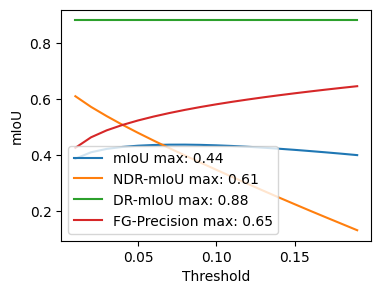

In [15]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(thresholds, mious, label='mIoU max: {:.2f}'.format(max(mious)))
plt.plot(thresholds, ndrmiou, label='NDR-mIoU max: {:.2f}'.format(max(ndrmiou)))
plt.plot(thresholds, drmiou, label='DR-mIoU max: {:.2f}'.format(max(drmiou)))
plt.plot(thresholds, precision, label='FG-Precision max: {:.2f}'.format(max(precision)))
plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()
plt.show()

# Report based on the best mIoU

In [19]:
idx = np.argmax(mious)
print('mIoU: {:.2f}, NDR-Recall: {:.2f}, DR-Recall: {:.2f}, Precision: {:.2f}'.format(mious[idx],
                                                                                      ndrmiou[idx],
                                                                                      drmiou[idx],
                                                                                      precision[idx]))


mIoU: 0.44, NDR-Recall: 0.40, DR-Recall: 0.88, Precision: 0.56
